In [1]:
import re
import os 
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import requests

from sklearn.preprocessing import StandardScaler
from tscluster.tsplot import tsplot as tsp
from tscluster.preprocessing.utils import ntf_to_tnf

# Census (ACS)

In [2]:
# state = "Illinois" # enter state name e.g. California

In [3]:
# state_to_zip_mapper = pd.read_csv(r".\geocorr2014_2126103015.csv")
# print(state_to_zip_mapper.shape)
# state_to_zip_mapper.head()

In [4]:
# print(state_to_zip_mapper["stab"].unique())

In [5]:
# state_abbr_df = pd.read_html("https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html")[0]
# state_abbr_df

In [6]:
# data_lst = []
# for col in range(len(state_abbr_df.columns)):
#     if col%2 == 0:
#         data_lst.append(pd.DataFrame(state_abbr_df.iloc[:, [col, col+1]].values, columns=["state", "state_abr"]))
# state_abbr_df_cleaned = pd.concat(data_lst).set_index("state")["state_abr"]
# state_abbr_df_cleaned

In [7]:
# state_abr = state_abbr_df_cleaned[state]
# state_abr

In [8]:
# state_to_zip_mapper[state_to_zip_mapper["stab"] == state_abr]["zcta5"].shape

In [9]:
par_dir = ".\ACS Data\MedianIncome"

In [10]:
cols = ['GEO_ID', 'NAME', 'S1903_C02_001E']

# 'S0101_C01_001E', 'S0101_C01_030E' Age_and_Sex
# 'S1501_C01_005E' 'S1501_C01_006E' education
# 'DP03_0009PE' employment
# 'S0201_130E' ForeignBorn # Not to be used since it has only 1Y estimate data and no zipcode level data
# 'S1903_C02_001E' MedianIncome

In [11]:
ACS_code = 'S1903'
ACS_cat = 'ST'
ACS_year_est = '5Y'

In [12]:
year = 2016
census_df = pd.read_csv(par_dir + r"\ACS" + f"{ACS_cat}{ACS_year_est}" + str(year) + f".{ACS_code}-Data.csv")[cols]
print(census_df.shape)
census_df.head()

(69, 3)


,GEO_ID,NAME,S1903_C02_001E
0,Geography,Geographic Area Name,Median income (dollars)!!Estimate!!Households
1,1600000US1714000,"Chicago city, Illinois",50434
2,8600000US60007,ZCTA5 60007,71089
3,8600000US60018,ZCTA5 60018,56456
4,8600000US60068,ZCTA5 60068,92474


In [13]:
zip_codes = census_df['NAME'].iloc[2:].apply(lambda x: x.split()[1]).astype(int).values
print(len(zip_codes))
zip_codes[:5]

67


array([60007, 60018, 60068, 60106, 60131])

In [14]:
base_cols = ['NAME'] 

features = ['S0101_C01_001E', 'S0101_C01_030E', 'S1501_C01_012E', 'S1501_C01_013E', 'S1501_C01_015E', 'S1501_C01_006E', 
            'DP03_0009PE', 'S1903_C02_001E']
folders = ['Age_and_Sex', 'Age_and_Sex', 'education', 'education', 'education', 'education', 'employment', 'MedianIncome']
ACS_categories = ['DP' if folder == 'employment' else 'ST' for folder in folders]

# 'S0101_C01_001E', 'S0101_C01_030E' Age_and_Sex
# 'S1501_C01_012E' 'S1501_C01_013E', 'S1501_C01_015E' 'S1501_C01_006E' education
# 'DP03_0009PE' employment
# 'S0201_130E' ForeignBorn # Not to be used since it has only 1Y estimate data and no zipcode level data
# 'S1903_C02_001E' MedianIncome

In [15]:
census_df_lst = []

for year in range(2011, 2020):
    init_df = pd.DataFrame({'zip_code': zip_codes})

    for i in range(len(features)):
        
        par_dir = f".\ACS Data\{folders[i]}"
    
        ACS_code = features[i].split("_")[0]
        ACS_cat = ACS_categories[i]
        ACS_year_est = '5Y'

        if year > 2016 and features[i] == 'S0101_C01_030E':
            cols = base_cols + ['S0101_C01_032E']
            rename_col_dict = {'NAME': 'zip_code', 'S0101_C01_032E': 'S0101_C01_030E'}

        elif year > 2016 and features[i] == 'S1903_C02_001E':
            cols = base_cols + ['S1903_C03_001E']
            rename_col_dict = {'NAME': 'zip_code', 'S1903_C03_001E': 'S1903_C02_001E'}

        else:
            cols = base_cols + [features[i]]
            rename_col_dict = {'NAME': 'zip_code'}

        df = pd.read_csv(par_dir + r"\ACS" + f"{ACS_cat}{ACS_year_est}" + str(year) + f".{ACS_code}-Data.csv")[cols].iloc[2:, :]

        df = df.rename(columns=rename_col_dict)

        df['zip_code'] = df['zip_code'].apply(lambda x: x.split()[1]).astype(int)

        init_df = init_df.merge(df, how='left', on='zip_code')

    float_cols = [i for i in features if i not in ('zip_code', 'S1501_C01_015E')]

    init_df.loc[:, float_cols] = init_df.loc[:, float_cols].astype(float)

    if year > 2014:
        init_df['S1501_C01_015E'] = 100 * (init_df['S1501_C01_012E'] + init_df['S1501_C01_013E']) / \
                                                        init_df['S1501_C01_006E']
        
    init_df['S1501_C01_015E'] = init_df['S1501_C01_015E'].astype(float)

    init_df = init_df.drop(['S1501_C01_006E', 'S1501_C01_012E', 'S1501_C01_013E'], axis=1)

    census_df_lst.append(init_df)

In [16]:
print(census_df_lst[5].shape)
census_df_lst[5].head()

(67, 6)


,zip_code,S0101_C01_001E,S0101_C01_030E,S1501_C01_015E,DP03_0009PE,S1903_C02_001E
0,60007,33733.0,43.1,35.452075,5.7,71089.0
1,60018,30519.0,38.5,24.417593,6.6,56456.0
2,60068,37567.0,44.2,56.514677,3.9,92474.0
3,60106,20215.0,36.2,17.644029,7.8,63073.0
4,60131,18072.0,39.4,18.317142,7.4,57385.0


In [17]:
census_df_lst[6].head()

,zip_code,S0101_C01_001E,S0101_C01_030E,S1501_C01_015E,DP03_0009PE,S1903_C02_001E
0,60007,33691.0,43.6,33.753715,5.7,73026.0
1,60018,30955.0,38.4,24.621032,5.7,59758.0
2,60068,37810.0,44.2,57.194647,3.3,98219.0
3,60106,20300.0,35.4,19.069363,6.3,62604.0
4,60131,18070.0,39.1,18.819450,6.9,60163.0


In [18]:
sum([df.isnull().sum().sum() for df in census_df_lst])

0

In [19]:
census_arr = np.array([census_df.iloc[:, 1:].values for census_df in census_df_lst])
print(census_arr.shape)
census_arr[:3, :3, :]

(9, 67, 5)


array([[[33868.0, 41.6, 33.7, 5.3, 69616.0],
        [28630.0, 38.1, 21.1, 7.1, 53459.0],
        [37272.0, 44.3, 51.4, 5.5, 90177.0]],

       [[33837.0, 42.9, 35.1, 5.3, 68184.0],
        [28957.0, 38.3, 22.8, 8.2, 57171.0],
        [37266.0, 44.4, 53.4, 5.7, 86621.0]],

       [[33973.0, 43.5, 35.7, 7.3, 67473.0],
        [28749.0, 39.9, 22.4, 8.1, 54688.0],
        [37421.0, 44.5, 53.8, 5.5, 87119.0]]], dtype=object)

In [20]:
census_features = [
    'Total population',
    'Median age (years)',
    'Percent BA or higher',
    'Percent Unemployed',
    'Household Income'
]

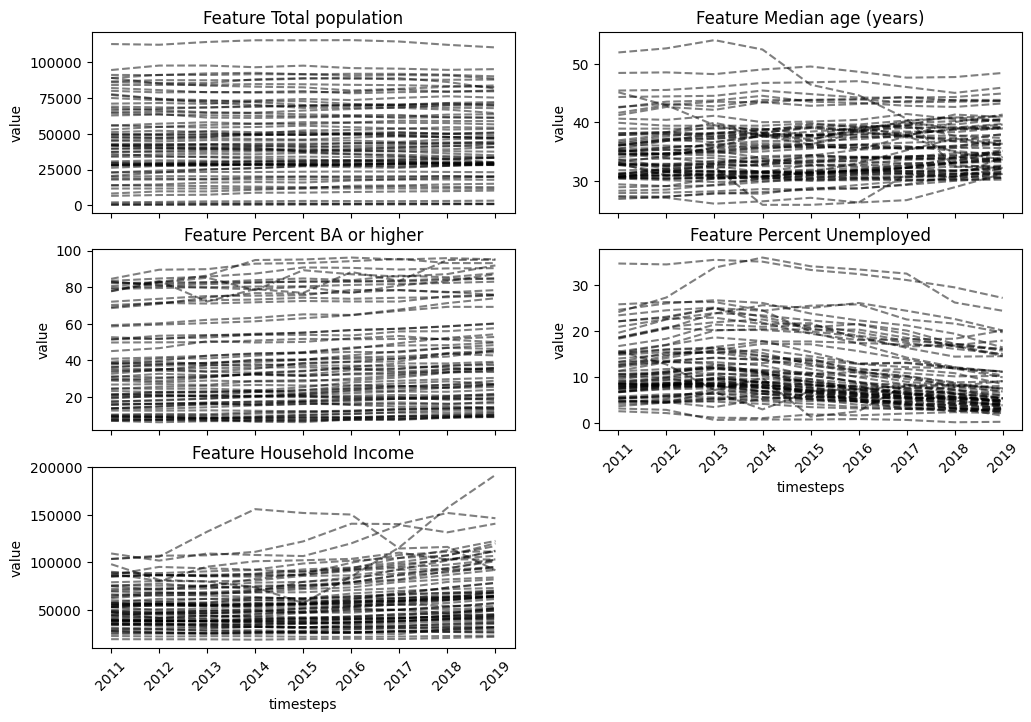

In [21]:
label_dict = {
    'T': np.arange(2011, 2020),
    'F': census_features
}

fig, ax = tsp.plot(X=census_arr, label_dict=label_dict, figsize=(12, 8), shape_of_subplot=(3, 2))
plt.show()

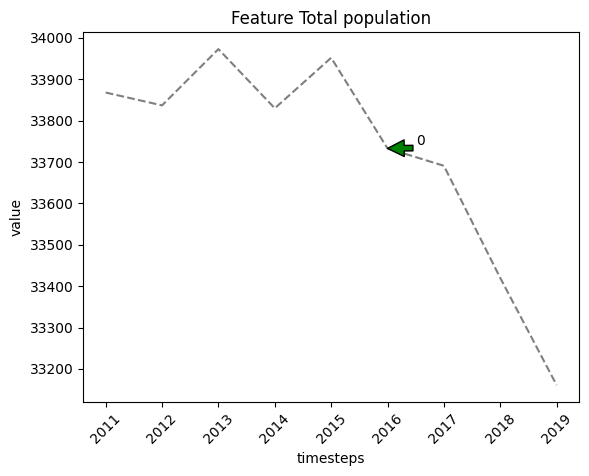

In [22]:
ei = 0
fig, ax = tsp.plot(X=census_arr[:, [ei], :1], label_dict=label_dict, entity_idx=[ei])
plt.show()

Scale

In [23]:
census_arr_scaled = []

for census_df in census_df_lst:

    scaler = StandardScaler()
    census_arr_scaled.append(scaler.fit_transform(census_df.iloc[:, 1:].values))

census_arr_scaled = np.array(census_arr_scaled)

print(census_arr_scaled.shape)
census_arr_scaled[:3, :3, :]

(9, 67, 5)


array([[[-0.43484135,  1.32620384, -0.12289486, -0.95825289,
          0.64953994],
        [-0.63225187,  0.63602452, -0.62947611, -0.67971518,
         -0.09055686],
        [-0.3065509 ,  1.85862789,  0.58873119, -0.92730426,
          1.5913689 ]],

       [[-0.44248497,  1.52297224, -0.09335186, -1.01774928,
          0.59937283],
        [-0.62839891,  0.63399488, -0.57658845, -0.59366889,
          0.09393418],
        [-0.31184994,  1.81285616,  0.62560991, -0.95925543,
          1.44553394]],

       [[-0.44184835,  1.59402755, -0.08587278, -0.75129891,
          0.49908237],
        [-0.64178766,  0.90276641, -0.60607152, -0.64414185,
         -0.04339461],
        [-0.30988228,  1.78604453,  0.62206686, -0.99240229,
          1.33267665]]])

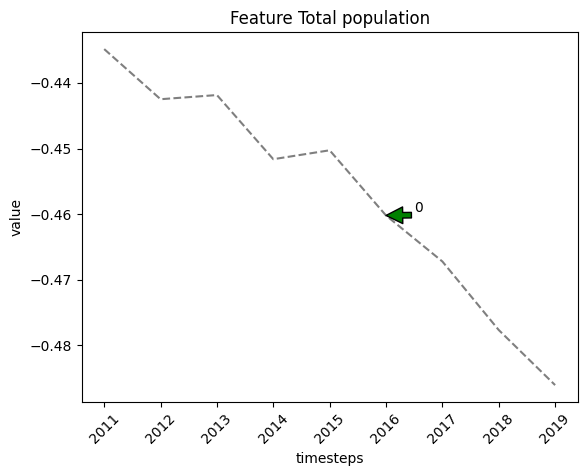

In [24]:
ei = 0
fig, ax = tsp.plot(X=census_arr_scaled[:, [ei], :1], label_dict=label_dict, entity_idx=[ei])
plt.show()

Scaling per entity

In [25]:
def scale_per_entity(X):
    ar = []
    for i in range(X.shape[1]):
        sc = StandardScaler()
        ar.append(sc.fit_transform(X[:, i, :]))

    return ntf_to_tnf(np.array(ar))

In [26]:
census_arr_scaled = scale_per_entity(census_arr)

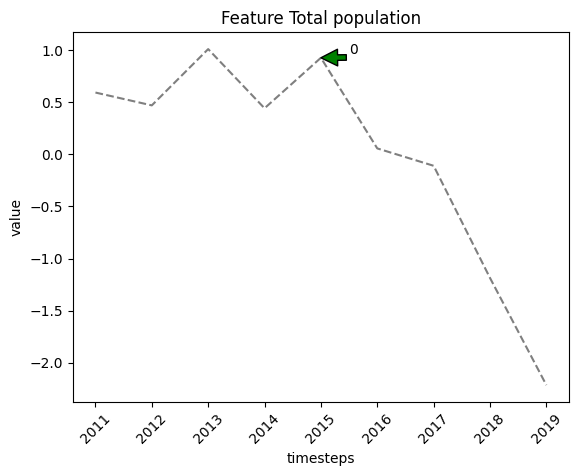

In [27]:
ei = 0
fig, ax = tsp.plot(X=census_arr_scaled[:, [ei], :1], label_dict=label_dict, entity_idx=[ei])
plt.show()

# BP

In [28]:
bp_df_2011 = pd.read_csv("Chicago_BP_API_Datasets_Art/2011.csv", compression='gzip')
print(bp_df_2011.shape)
bp_df_2011.head()

(134790, 3)


,ESTAB,NAICS2007,zipcode
0,61,52,19312
1,45,52,19348
2,142,52,20006
3,5,52,19344
4,6,52,19343


In [29]:
bp_df_2011.dtypes

ESTAB        int64
NAICS2007    int64
zipcode      int64
dtype: object

In [30]:
# response = requests.get("https://api.census.gov/data/2016/zbp/variables/NAICS2012.json")
# response.ok

In [31]:
# with open('NAICS2012.json', 'w') as f:
#     json.dump(response.json()['values']['item'], f)

In [32]:

with open(r"NAICS2012.json", "r") as f:
    NAICS_dict = json.load(f)

In [33]:
chosen_NAICS_2011 = ['52', '54', '55', '62', '72', '71']
chosen_NAICS = ['52', '54', '55', '62', '72', '71']

for i in chosen_NAICS:
    print(f"{i} -> {NAICS_dict[str(i)]}")

52 -> Finance and insurance
54 -> Professional, scientific, and technical services
55 -> Management of companies and enterprises
62 -> Health care and social assistance
72 -> Accommodation and food services
71 -> Arts, entertainment, and recreation


In [34]:
bp_df_lst = []

for year in range(2000, 2020):

    df = pd.read_csv(f"Chicago_BP_API_Datasets_Art/{year}.csv", compression='gzip')

    if year >= 1998 and year <= 2002:
        naics = "NAICS1997"
        
    elif year >= 2003 and year <= 2007:
        naics = "NAICS2002"

    elif year >= 2008 and year <= 2011:
        naics = "NAICS2007"
        
    elif year >= 2012 and year <= 2016:
        naics = "NAICS2012" 
        
    elif year >= 2017 and year <= 2022:
        naics = "NAICS2017"

    if year <= 2011:
        zipcode = 'zipcode'
        # chosen_NAICS = chosen_NAICS_2011
    else:
        zipcode= 'zip code'
        # chosen_NAICS = chosen_NAICS_after_2011

    df = df.rename(columns={naics: 'NAICS', zipcode: 'zip_code'})

    df['ESTAB'] = df['ESTAB'].astype(int)
    df['zip_code'] = df['zip_code'].astype(int)
    df['NAICS'] = df['NAICS'].astype(str)

    df['NAICS'] = df['NAICS'].apply(lambda x: '31-33' if x == '31' else x)

    df = df[(df['zip_code'].isin(zip_codes)) & (df['NAICS'].isin(chosen_NAICS))]

    df = df.pivot(index='zip_code', columns='NAICS', values='ESTAB')

    bp_df = pd.DataFrame({'zip_code': zip_codes}).merge(df, how='left', on='zip_code')

    bp_df_lst.append(bp_df)

    print(f"Done with year {year}")

print(bp_df_lst[0].shape)

bp_df_lst[-1].head()

Done with year 2000
Done with year 2001
Done with year 2002
Done with year 2003
Done with year 2004
Done with year 2005
Done with year 2006
Done with year 2007
Done with year 2008
Done with year 2009
Done with year 2010
Done with year 2011
Done with year 2012
Done with year 2013
Done with year 2014
Done with year 2015
Done with year 2016
Done with year 2017
Done with year 2018
Done with year 2019
(67, 7)


,zip_code,52,54,55,62,71,72
0,60007,80.0,159.0,18.0,148.0,16.0,123.0
1,60018,117.0,189.0,49.0,84.0,17.0,171.0
2,60068,99.0,237.0,3.0,271.0,21.0,77.0
3,60106,23.0,55.0,4.0,29.0,9.0,42.0
4,60131,22.0,26.0,4.0,38.0,5.0,50.0


In [35]:
bp_df_lst[0].head()

,zip_code,52,54,55,62,71,72
0,60007,74.0,158.0,34.0,111.0,9.0,110.0
1,60018,148.0,240.0,45.0,65.0,5.0,105.0
2,60068,134.0,251.0,10.0,196.0,12.0,64.0
3,60106,34.0,81.0,9.0,22.0,6.0,45.0
4,60131,23.0,41.0,8.0,34.0,3.0,44.0


In [36]:
bp_df_lst[-1].isnull().sum()

zip_code     0
52           1
54           0
55          30
62           0
71           5
72           0
dtype: int64

In [37]:
bp_df_lst[-1].describe()

,zip_code,52,54,55,62,71,72
count,67.000000,66.000000,67.000000,37.000000,67.000000,62.000000,67.000000
mean,60590.104478,74.681818,172.895522,16.837838,117.089552,20.290323,115.179104
std,165.458237,112.552369,221.446015,21.251815,76.731277,18.748016,81.553649
min,60007.000000,3.000000,5.000000,3.000000,10.000000,3.000000,18.000000
25%,60611.500000,23.750000,31.000000,4.000000,60.000000,6.000000,54.000000
50%,60629.000000,52.500000,88.000000,6.000000,97.000000,12.000000,90.000000
75%,60646.500000,81.500000,246.500000,20.000000,146.500000,27.000000,164.500000
max,60827.000000,864.000000,1048.000000,92.000000,404.000000,73.000000,331.000000


In [38]:
bp_df_lst[-1][bp_df_lst[-1]['55'].isnull()]

,zip_code,52,54,55,62,71,72
20,60615,26.0,68.0,NaN,92.0,11.0,78.0
22,60617,35.0,40.0,NaN,140.0,6.0,90.0
23,60618,100.0,265.0,NaN,198.0,57.0,216.0
24,60619,37.0,24.0,NaN,129.0,NaN,69.0
25,60620,32.0,17.0,NaN,76.0,6.0,68.0
26,60621,3.0,6.0,NaN,57.0,NaN,21.0
29,60624,7.0,11.0,NaN,52.0,NaN,23.0
30,60625,56.0,162.0,NaN,188.0,40.0,159.0
31,60626,32.0,57.0,NaN,81.0,18.0,83.0
32,60628,23.0,18.0,NaN,90.0,7.0,64.0


In [39]:
bp_df_lst[-1][bp_df_lst[-1]['71'].isnull()]

,zip_code,52,54,55,62,71,72
24,60619,37.0,24.0,NaN,129.0,NaN,69.0
26,60621,3.0,6.0,NaN,57.0,NaN,21.0
29,60624,7.0,11.0,NaN,52.0,NaN,23.0
39,60636,16.0,7.0,NaN,30.0,NaN,34.0
53,60652,15.0,22.0,NaN,54.0,NaN,52.0


In [40]:
bp_df_lst[-2][bp_df_lst[-2]['71'].isnull()]

,zip_code,52,54,55,62,71,72
24,60619,34.0,24.0,NaN,132.0,NaN,65.0
26,60621,3.0,4.0,NaN,61.0,NaN,20.0
29,60624,7.0,11.0,NaN,48.0,NaN,24.0
39,60636,16.0,7.0,NaN,31.0,NaN,29.0
47,60644,6.0,9.0,NaN,57.0,NaN,30.0


In [41]:
bp_df_lst[-3][bp_df_lst[-3]['71'].isnull()]

,zip_code,52,54,55,62,71,72
5,60176,11.0,25.0,4.0,11.0,NaN,48.0
24,60619,37.0,21.0,NaN,132.0,NaN,62.0
26,60621,4.0,5.0,NaN,61.0,NaN,20.0
29,60624,6.0,11.0,NaN,46.0,NaN,26.0
32,60628,22.0,17.0,NaN,93.0,NaN,67.0
39,60636,18.0,8.0,NaN,32.0,NaN,36.0
47,60644,7.0,11.0,NaN,54.0,NaN,33.0
54,60653,16.0,20.0,NaN,54.0,NaN,29.0


In [42]:
bp_df_lst[-4][bp_df_lst[-4]['71'].isnull()]

,zip_code,52,54,55,62,71,72
39,60636,19.0,8.0,2.0,33.0,NaN,36.0


In [44]:
for i in range(len(bp_df_lst)):
    print(f"year {np.arange(2000, 2020)[i]}, {bp_df_lst[i].shape[0]} zipcodes, {bp_df_lst[i][bp_df_lst[i]['71'].isnull()].shape[0]} has nan")
    

year 2000, 67 zipcodes, 2 has nan
year 2001, 67 zipcodes, 2 has nan
year 2002, 67 zipcodes, 2 has nan
year 2003, 67 zipcodes, 3 has nan
year 2004, 67 zipcodes, 3 has nan
year 2005, 67 zipcodes, 3 has nan
year 2006, 67 zipcodes, 2 has nan
year 2007, 67 zipcodes, 1 has nan
year 2008, 67 zipcodes, 1 has nan
year 2009, 67 zipcodes, 1 has nan
year 2010, 67 zipcodes, 1 has nan
year 2011, 67 zipcodes, 0 has nan
year 2012, 67 zipcodes, 0 has nan
year 2013, 67 zipcodes, 0 has nan
year 2014, 67 zipcodes, 0 has nan
year 2015, 67 zipcodes, 0 has nan
year 2016, 67 zipcodes, 1 has nan
year 2017, 67 zipcodes, 8 has nan
year 2018, 67 zipcodes, 5 has nan
year 2019, 67 zipcodes, 5 has nan


In [57]:
# bp_df_lst[-4][bp_df_lst[-4]['zip_code'].isin([60621, 60637, 60649, 60827])]

In [58]:
# bp_df_lst[-4][bp_df_lst[-5]['zip_code'].isin([60621, 60637, 60649, 60653])]

Drop NAICS code 55

In [45]:
chosen_NAICS

['52', '54', '55', '62', '72', '71']

In [46]:
chosen_NAICS = ['52', '54', '62', '72', '71']

Fill Nans with Zeros

In [47]:
for i in range(len(bp_df_lst)):
    bp_df_lst[i] = bp_df_lst[i].fillna(0)

In [48]:
bp_arr = np.array([bp_df[chosen_NAICS].values for bp_df in bp_df_lst])
print(bp_arr.shape)
bp_arr[:3, :3, :]

(20, 67, 5)


array([[[ 74., 158., 111., 110.,   9.],
        [148., 240.,  65., 105.,   5.],
        [134., 251., 196.,  64.,  12.]],

       [[ 67., 179., 114., 111.,   9.],
        [146., 234.,  61., 114.,   4.],
        [133., 262., 210.,  69.,  12.]],

       [[ 68., 188., 125., 107.,  14.],
        [143., 226.,  53., 111.,   4.],
        [127., 270., 206.,  65.,  11.]]])

In [49]:
np.isnan(bp_arr).sum()

0

In [50]:
NAICS_names = [NAICS_dict[k] for k in chosen_NAICS]
NAICS_names

['Finance and insurance',
 'Professional, scientific, and technical services',
 'Health care and social assistance',
 'Accommodation and food services',
 'Arts, entertainment, and recreation']

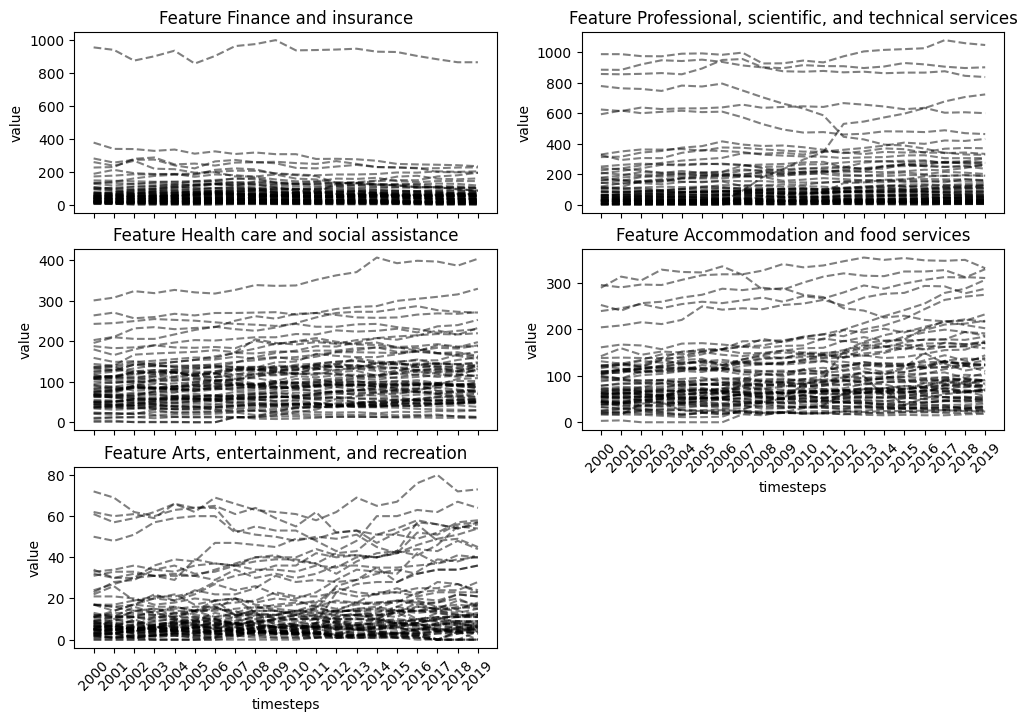

In [51]:
label_dict = {
    'T': np.arange(2000, 2020),
    'F': NAICS_names
}

fig, ax = tsp.plot(X=bp_arr, label_dict=label_dict, figsize=(12, 8), shape_of_subplot=(3, 2))
plt.show()

Scale

In [52]:
# bp_arr_scaled = []

# for bp_df in bp_df_lst:

#     scaler = StandardScaler()
#     bp_arr_scaled.append(scaler.fit_transform(bp_df[chosen_NAICS].values))

# bp_arr_scaled = np.array(bp_arr_scaled)

# print(bp_arr_scaled.shape)
# bp_arr_scaled[:3, :3, :]

Scaling per entity

In [53]:
bp_arr_scaled = scale_per_entity(bp_arr)
print(bp_arr_scaled.shape)
bp_arr_scaled[:3, :3, :]

(20, 67, 5)


array([[[-0.71250559, -1.28074036, -1.68381827, -0.83153236,
         -2.09255535],
        [ 1.08735493,  2.36130132, -0.50663335, -1.57337519,
         -0.81115571],
        [ 1.04569161, -0.08178019, -1.7064077 , -1.20482899,
         -0.79656623]],

       [[-1.49794483,  0.49454331, -1.43800538, -0.70458086,
         -2.09255535],
        [ 0.92384291,  1.98993021, -0.83349357, -1.18595038,
         -1.02184551],
        [ 0.97256632,  0.77496466, -1.21736558, -0.05737281,
         -0.79656623]],

       [[-1.38573923,  1.25537916, -0.53669147, -1.21238688,
         -0.55391171],
        [ 0.67857488,  1.49476873, -1.48721402, -1.31509198,
         -1.02184551],
        [ 0.5338146 ,  1.39805182, -1.3570919 , -0.97533776,
         -1.11519273]]])

# Merge

In [46]:
census_arr_scaled[:3, :3, :]

array([[[-0.43484135,  1.32620384, -0.12289486, -0.95825289,
          0.64953994],
        [-0.63225187,  0.63602452, -0.62947611, -0.67971518,
         -0.09055686],
        [-0.3065509 ,  1.85862789,  0.58873119, -0.92730426,
          1.5913689 ]],

       [[-0.44248497,  1.52297224, -0.09335186, -1.01774928,
          0.59937283],
        [-0.62839891,  0.63399488, -0.57658845, -0.59366889,
          0.09393418],
        [-0.31184994,  1.81285616,  0.62560991, -0.95925543,
          1.44553394]],

       [[-0.44184835,  1.59402755, -0.08587278, -0.75129891,
          0.49908237],
        [-0.64178766,  0.90276641, -0.60607152, -0.64414185,
         -0.04339461],
        [-0.30988228,  1.78604453,  0.62206686, -0.99240229,
          1.33267665]]])

In [47]:
chicago_arr = np.concatenate((bp_arr_scaled, census_arr_scaled), axis=2)
print(chicago_arr.shape)
chicago_arr[:3, :3, :]

(9, 67, 11)


array([[[ 5.75068381,  0.14734461,  0.12218546,  0.0587262 ,
          0.33128261,  0.12882848, -0.43484135,  1.32620384,
         -0.12289486, -0.95825289,  0.64953994],
        [ 0.6377077 ,  0.3966398 ,  1.10737136,  0.19098354,
         -0.61079566,  0.68340645, -0.63225187,  0.63602452,
         -0.62947611, -0.67971518, -0.09055686],
        [-0.60424549,  0.23044301,  0.66169202,  0.38936953,
          2.12979567, -0.46840933, -0.3065509 ,  1.85862789,
          0.58873119, -0.92730426,  1.5913689 ]],

       [[ 5.80200291,  0.10234197,  0.16476877,  0.02065838,
          0.46760095,  0.26893969, -0.44248497,  1.52297224,
         -0.09335186, -1.01774928,  0.59937283],
        [ 0.65493153,  0.34249953,  0.93823746,  0.11449644,
         -0.52293584,  0.74831733, -0.62839891,  0.63399488,
         -0.57658845, -0.59366889,  0.09393418],
        [-0.59925992,  0.26796787,  0.42259167,  0.40539443,
          2.23641666, -0.4642261 , -0.31184994,  1.81285616,
          0.62560991,

In [48]:
np.save("chicago_arr.npy", chicago_arr)

In [49]:
np.save("chicago_census_arr_scaled.npy", census_arr_scaled)

In [54]:
np.save("chicago_bp_arr_scaled.npy", bp_arr_scaled)

In [51]:
np.save("Chicago_zip_codes.npy", zip_codes)